In [ ]:
from pathlib import Path
import mne
import sys
import pyedflib
import matplotlib.pyplot as plt
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath)) 

In [2]:
import sys, importlib.util, os
print("Root on path?", any(p.endswith("Motor-Imagery-EEG-Classifier") for p in sys.path))
print("Found src?", importlib.util.find_spec("src") is not None)
print("PYTHONPATH=", os.environ.get("PYTHONPATH"))


Root on path? True
Found src? True
PYTHONPATH= None


In [ ]:
from src.utils_io import set_seeds, edfMetadata, read_channel
set_seeds(42)

In [27]:
rawData = Path(f"{parentPath}/data/raw/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf")
raw = mne.io.read_raw_edf(str(rawData), preload=True, verbose=False)
print(raw)
print("Sampling rate:", raw.info["sfreq"], "Hz")

<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>
Sampling rate: 160.0 Hz


In [4]:
rawData = Path(f"{parentPath}/data/raw/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf")
edf_reader = pyedflib.EdfReader(str(rawData))
edf_metadata = edfMetadata(edf_reader)

In [5]:
print("nChannels:", edf_metadata["nChannels"])
print("channelLabels:", edf_metadata["channelLabels"])
print("sampleRates:", edf_metadata["sampleRates"][:5], "...")
print("prefilter (first few):", edf_metadata["prefilter"][:5])


nChannels: 64
channelLabels: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
sampleRates: [160.0, 160.0, 160.0, 160.0, 160.0] ...
prefilter (first few): ['HP:0Hz LP:0Hz N:0Hz', 'HP:0Hz LP:0Hz N:0Hz', 'HP:0Hz LP:0Hz N:0Hz', 'HP:0Hz LP:0Hz N:0Hz', 'HP:0Hz LP:0Hz N:0Hz']


In [42]:

edf_metadata["channelLabels"][0]          

'Fc5.'

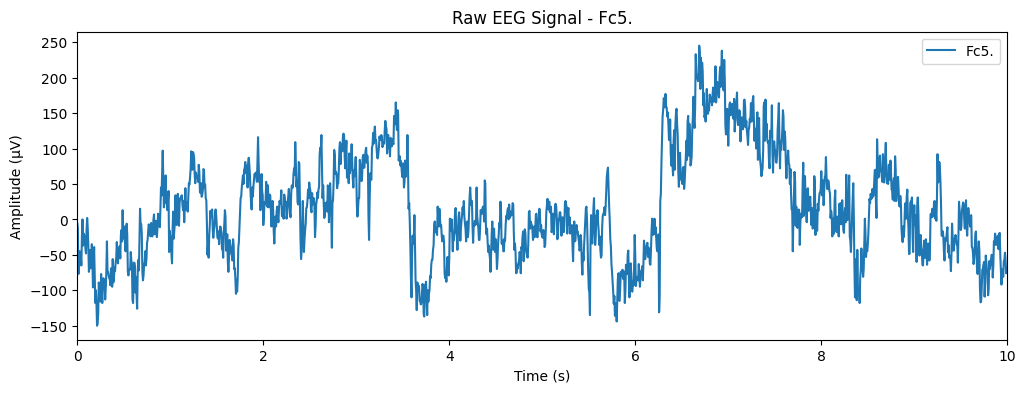

In [43]:
# Pick a channel by label or index
channel_number = 0  # first channel
channel_label = edf_metadata["channelLabels"][channel_number]          
time, signal, fs, channel_label = read_channel(edf_reader, channel_label, start_sec=0, stop_sec=10)  # first 10s


plt.figure(figsize=(12, 4))
plt.plot(time, signal, label=channel_label)
plt.title(f"Raw EEG Signal - {channel_label}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.xlim(0, 10)
plt.legend()
# plt.grid()
plt.show()

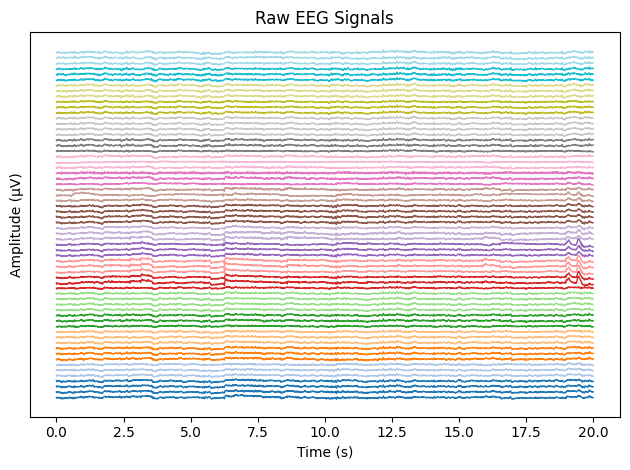

In [41]:
# Plot all channel 

start_sec = 0
stop_sec = 20

for channel_label in edf_metadata["channelLabels"]:
    time, signal, fs, channel_label = read_channel(edf_reader, channel_label, start_sec=start_sec, stop_sec=stop_sec)
    plt.plot(time, signal + 500 * edf_metadata["channelLabels"].index(channel_label), # Offset for visibility
             label=channel_label, 
             color=plt.cm.tab20(edf_metadata["channelLabels"].index(channel_label) / len(edf_metadata["channelLabels"])),
             linewidth=1)  
plt.title("Raw EEG Signals")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.yticks([])  # Hide y-ticks for clarity
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [ ]:
# basic clean: notch + bandpass + average reference
raw_proc = raw.load_data()
# power noise =  60 Hz for US, 50 elsewhere
raw_proc.notch_filter([60], verbose=False)
raw_proc.filter(l_freq=1., h_freq=40., phase='zero', fir_design='firwin', verbose=False)
raw_proc, _ = mne.set_eeg_reference(raw_proc, 'average')
print(raw_proc)


In [ ]:
# visualize raw data
mne.viz.plot_raw(raw_proc, duration=5.0, n_channels=16, scalings="auto", title="Cleaned EEG (5s)")


In [ ]:
raw.plot_psd(fmin=1, fmax=40, average=True)

In [ ]:
# quick PSD (Welch)

raw_proc.plot_psd(fmin=1, fmax=40, average=True)


: 